Here we are preparing a dataset for semantic segmentation. We will only use the CBIS-DDSM images and will use the masks as labels. The functions will be updated to process the masks and images in the same way and return the masks at the same time.

In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import random
import shutil
import re
from scipy.misc import imresize
from mammo_utils import create_mask, half_image, get_fuzzy_offset, progress, clean_name, random_flip_image
%matplotlib inline

In [36]:
## randomly rotate an image
def random_rotate_image(img, mask):
    rotations = np.random.randint(low=-3, high=3)
    rotated_img = np.rot90(img, rotations)
    rotated_mask = np.rot90(mask, rotations)
    return rotated_img, rotated_mask

## randomly flip an image left-right, up-down or both and return it
def random_flip_image(img, mask):
    fliplr = np.random.binomial(1,0.5)
    flipud = np.random.binomial(1,0.5)
    
    if fliplr:
        img = np.flip(img, 1)
        mask = np.flip(mask, 1)
    if flipud:
        img = np.flip(img, 0)
        mask = np.flip(mask, 0)
        
    return random_rotate_image(img, mask)

def get_roi_edges(center_col, center_row, img_height, img_width, fuzz_offset_w=0, fuzz_offset_h=0, scale_factor=1, slice_size=320):
    # slice margin
    slice_margin = slice_size // 3
    
    # figure out the new center of the ROI
    center_col_scaled = int(center_col * scale_factor)
    center_row_scaled = int(center_row * scale_factor)
    
    start_col = center_col_scaled - slice_margin + fuzz_offset_h
    end_col = start_col + slice_size
    
    if start_col < 0:
        start_col = 20
        end_col = start_col + slice_size
    elif end_col > (img_width - 20):
        end_col = img_width - 20
        start_col = end_col - slice_size
        
    start_row = center_row_scaled - slice_margin + fuzz_offset_w
    end_row = start_row + slice_size
    
    if start_row < 0:
        start_row = 20
        end_row = start_row + slice_size
    elif end_row > (img_height - 20):
        end_row = img_height - 20
        start_row = end_row - slice_size           
     
    return start_row, end_row, start_col, end_col

def random_crop_image(img, mask, slice_size=576, tile_size=320):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # make sure the image is big enough to use
    if (img_h < slice_size) or (img_w < slice_size):
        print("Error - image is wrong size!", img.shape)
        return np.array([0])
    
    # pick a random place to start the crop so that the crop will be the right size
    start_row = np.random.randint(low=0, high=(img_h - slice_size))
    start_col = np.random.randint(low=0, high=(img_w - slice_size))
    
    end_row = start_row + slice_size
    end_col = start_col + slice_size
    
    # crop the image and randomly rotate it
    cropped_img = img[start_row:end_row, start_col:end_col]
    cropped_mask = mask[start_row:end_row, start_col:end_col]
    
    cropped_img, cropped_mask = random_flip_image(cropped_img, cropped_mask)
    
    # make sure the image is the right size and not mostly black
    if (cropped_img.shape[0] == cropped_img.shape[1]) and (np.sum(cropped_img <= 10) <= (slice_size * slice_size * 0.9)):
        # resize it and return it
        cropped_img = imresize(cropped_img, (tile_size,tile_size))
        cropped_mask = imresize(cropped_mask, (tile_size,tile_size))
        return cropped_img.reshape((tile_size, tile_size, 1)), cropped_mask.reshape((tile_size, tile_size, 1))
    
    # else repeat until the image is the right size
    else:
        return random_crop_image(img, mask)
    
#########################################################
## For abnormal images, extract the ROI based on the mask
## Extract each ROI in 3 ways:
##     1. At size, centered with random offset
##     2. With 1.5 times context and random flip and rotate
##     3. Zoomed so it all fits
def create_cbis_slices(mask_dir, image_dir, labels, slice_size=320, debug=True):
    # initialize return variables
    slices_list = []
    label_list = []
    filenames_list = []
    roi_sizes = []
    
    # we will extract the tiles at regular size and then size them down to 320x320
    full_slice_size = 598
    
    # get list of files in the directory
    mask_files = os.listdir(mask_dir)
    counter = 0
    
    # display the progress bar
    if debug is None:
        progress(counter, len(mask_files), 'WORKING')
        
        
    # loop through the masks
    for mask in mask_files:
        
        # update the progress bar
        counter += 1
        if debug is None:
            progress(counter, len(mask_files), mask)
            
        # get the image name
        base_image_file = clean_name(mask)
        
        # try some variations to open the image
        try:
            full_image = PIL.Image.open(image_dir + "/" + base_image_file + '_FULL.jpg')
        except:
            try:
                full_image = PIL.Image.open(image_dir + "/" + base_image_file + "000000.jpg")
            except:
                try:
                    full_image = PIL.Image.open(image_dir + "/" + base_image_file + "000001.jpg")
                except:
                    print("Error FileNotFound:", base_image_file)
                    continue
        
        mask_image = PIL.Image.open(os.path.join(mask_dir, mask))
        
        # get the label
        try:
            label = labels.loc[base_image_file + ".jpg"]['CLASS']
        except:
            print("Label not found", base_image_file)
            continue
        
        # turn the image into an array and drop the unneeded dimensions
        full_image_arr = np.array(full_image)[:,:,0]
        mask_image = np.array(mask_image)[:,:,0]
        
        # get the mask
        center_row, center_col, too_big, full_image_arr, mask_size = create_mask(mask_dir + "/" + mask, full_image_arr, half=False, output=debug)
        
        # get the height and width of the image
        image_h, image_w = full_image_arr.shape
        
        # get the roi size from the mask
        try:
            mask_height = mask_size[0]
            mask_width = mask_size[1]
            roi_size = np.max([mask_height, mask_width])
            if debug:
                print("Mask", mask, " Height:", mask_height, "Width:", mask_width)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
            
        # add the ROI size the the list - we will use this for cropping the normal images
        roi_sizes.append(roi_size)
        
        # if there is a problem with the location of the ROI skip this one
        if (center_row == 0) and (center_col == 0):
            print("Error, skipping", mask)
            continue
        
        ###########################################################################
        ## Extract the ROI depending on it's size
        # if the ROI is smaller than a slice extract it with some padding
        if roi_size < full_slice_size:
            if debug:
                print("ROI small", mask)
            
            ## Make sure the size of the ROI is at least as big as a tile will be
            adj_mask_height = int(np.max([full_slice_size * 1.2, mask_height]))
            adj_mask_width = int(np.max([full_slice_size * 1.2, mask_width]))

            ## Extract the full ROI with 20% padding on either side
            start_row = int(np.max([center_row - (adj_mask_height // 2), 0]))
            end_row = start_row + adj_mask_height
            if end_row > image_h:
                end_row = image_h
                start_row = image_h - adj_mask_height

            start_col = int(np.max([center_col - (adj_mask_width // 2), 0]))
            end_col = start_col + adj_mask_width
            if end_col > image_w:
                end_col = image_w
                start_col = image_w - adj_mask_width

            # extract the ROI and randomly flip it
            cropped_roi = full_image_arr[start_row:end_row, start_col:end_col]
            cropped_mask = mask_image[start_row:end_row, start_col:end_col]
            roi_img, roi_mask = random_flip_image(cropped_roi, cropped_mask)
            
        # else just extract the ROI with no padding
        else:
            if debug:
                print("ROI Big", mask)
            
            # we will still use a small amount of padding as it is necessary for the random cropping
            adj_mask_height = int(np.max([full_slice_size * 1.05, mask_height]))
            adj_mask_width = int(np.max([full_slice_size * 1.05, mask_width]))
            
            start_row = np.max([center_row - (adj_mask_height // 2), 0])
            end_row = start_row + adj_mask_height
            if end_row > image_h:
                end_row = image_h
                start_row = image_h - adj_mask_height

            start_col = np.max([center_col - (adj_mask_width // 2), 0])
            end_col = start_col + adj_mask_width
            if end_col > image_w:
                end_col = image_w
                start_col = image_w - adj_mask_width

            # extract the ROI and randomly flip it
            cropped_roi = full_image_arr[start_row:end_row, start_col:end_col]
            cropped_mask = mask_image[start_row:end_row, start_col:end_col]
            roi_img, roi_mask = random_flip_image(cropped_roi, cropped_mask)
        
        ###########################################################################
        ## Now we have an image that is just the ROI, with or without padding
        ## Take 3 random crops from it
        slice_1, label_1 = random_crop_image(roi_img, roi_mask)
        slice_2, label_2 = random_crop_image(roi_img, roi_mask)
        slice_3, label_3 = random_crop_image(roi_img, roi_mask)
        
        # for each of the slices, if it is sized properly add it to the list
        if (slice_1.shape[0] == slice_size) and (slice_1.shape[1] == slice_size):
            if np.sum(slice_1 <= 10) <= (slice_size * slice_size * 0.9):
                slices_list.append(slice_1)
                label_list.append(label_1)
                filenames_list.append(base_image_file + ".jpg")
        
        if (slice_2.shape[0] == slice_size) and (slice_2.shape[1] == slice_size):
            if np.sum(slice_2 <= 10) <= (slice_size * slice_size * 0.9):
                slices_list.append(slice_2)
                label_list.append(label_2)
                filenames_list.append(base_image_file + ".jpg")
        
        if (slice_3.shape[0] == slice_size) and (slice_3.shape[1] == slice_size):
            if np.sum(slice_3 <= 10) <= (slice_size * slice_size * 0.9):
                slices_list.append(slice_3)
                label_list.append(label_3)
                filenames_list.append(base_image_file + ".jpg")
        
        # if the ROI is bigger than the slice take 1 more crop
#         if roi_size > full_slice_size:
#             slice_1, label_1 = random_crop_image(roi_img, roi_mask)
            
#             if (slice_1.shape[0] == slice_size) and (slice_1.shape[1] == slice_size):
#                 if np.sum(slice_1 <= 10) <= (slice_size * slice_size * 0.9):
#                     slices_list.append(slice_1)
#                     label_list.append(label_1)
#                     filenames_list.append(base_image_file + ".jpg")
        
        # if the ROI is 1.5 times bigger than the slice take one more crop
        if roi_size > (full_slice_size * 1.5):
            slice_2, label_2 = random_crop_image(roi_img, roi_mask)
            
            if (slice_2.shape[0] == slice_size) and (slice_2.shape[1] == slice_size):
                if np.sum(slice_2 <= 10) <= (slice_size * slice_size * 0.9):
                    slices_list.append(slice_2)
                    label_list.append(label_2)
                    filenames_list.append(base_image_file + ".jpg")

        # if the ROI is double the size of the ROI take one more crop
        if roi_size > (full_slice_size * 2):
            slice_2, label_2 = random_crop_image(roi_img, roi_mask)
            
            if (slice_2.shape[0] == slice_size) and (slice_2.shape[1] == slice_size):
                if np.sum(slice_2 <= 10) <= (slice_size * slice_size * 0.9):
                    slices_list.append(slice_2)
                    label_list.append(label_2)
                    filenames_list.append(base_image_file + ".jpg")
        
        ###########################################################################
        ## Now we will take just some random crops of the image, ignoring the ROI
        for foo in range(12):       
            try:
                slice_4, label_4 = random_crop_image(full_image_arr, mask_image)

                # make sure the size is right
                if (slice_4.shape[0] == slice_size) and (slice_4.shape[1] == slice_size):
                    # make sure the image isn't all black
                    if np.sum(slice_4 <= 10) <= (slice_size * slice_size * 0.9):
                        slices_list.append(slice_4)
                        label_list.append(label_4)
                        filenames_list.append(base_image_file + ".jpg")
            except:
                continue

    # return the data
    return np.array(slices_list), np.array(label_list), np.array(filenames_list), roi_sizes

In [45]:
def plot_random_samples(images, labels, names, N=20):
    idxs = random.sample(range(len(images)), k=N)

    for idx in idxs:
        f, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(images[idx].reshape(320,320))
        ax[0].set_title(names[idx] + " IM - " + str(idx))
        ax[1].imshow(labels[idx].reshape(320,320))
        ax[1].set_title(names[idx] + " LA - " + str(idx))
        plt.show()

## Calc Test

In [37]:
# load the labels
test_labels = pd.read_pickle(os.path.join("data", "test_labels.pkl"))
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Calc Test All Mask JPEGs"
image_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Calc Test All Full JPEGs"

calc_test_slices, calc_test_labels, calc_testfilenames, calc_test_roi_sizes = create_cbis_slices(mask_dir, image_dir, labels=test_labels, debug=None)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:77: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Calc Test All Mask JPEGs/P_01217_RIGHT_CC000001_1.jpg
Mask Size Error: 0 for P_01217_RIGHT_CC000001_1.jpg
Error, skipping P_01217_RIGHT_CC000001_1.jpg
Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Calc Test All Mask JPEGs/P_01460_LEFT_MLO000001_2.jpg
Mask Size Error: 0 for P_01460_LEFT_MLO000001_2.jpg
Error, skipping P_01460_LEFT_MLO000001_2.jpg


In [38]:
print("Calc Test Slices shape:", calc_test_slices.shape)
print("Calc Test Labels:", calc_test_labels.shape)
print("Calc Test File Name List:", len(calc_testfilenames))

Calc Test Slices shape: (4731, 320, 320, 1)
Calc Test Labels: (4731, 320, 320, 1)
Calc Test File Name List: 4731


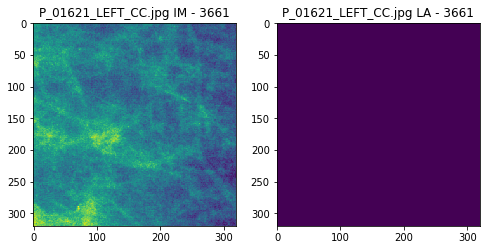

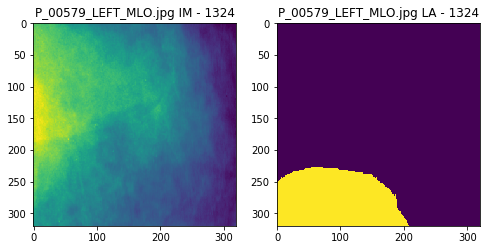

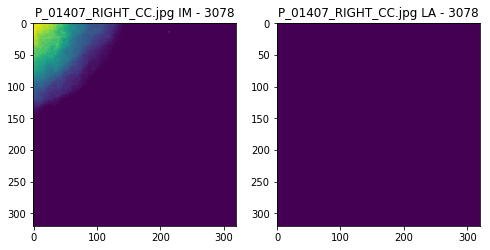

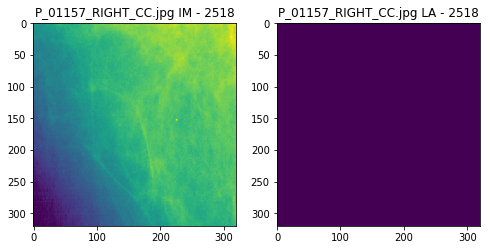

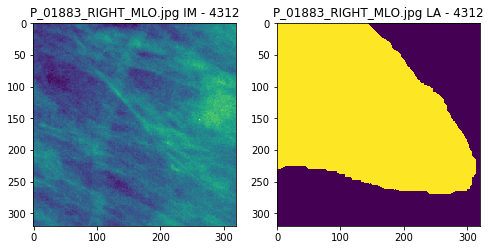

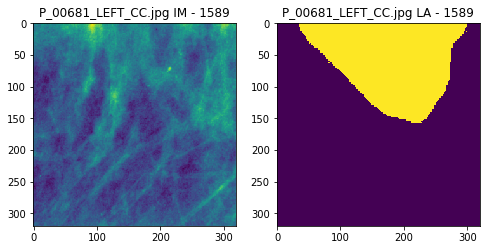

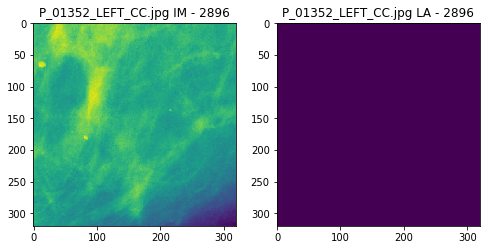

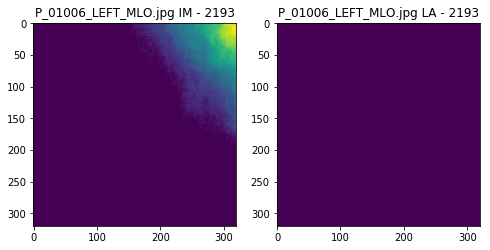

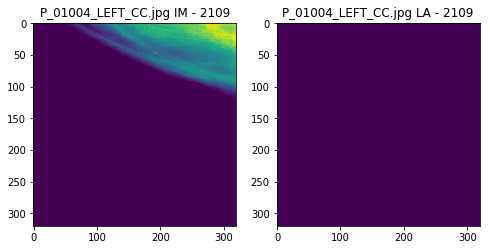

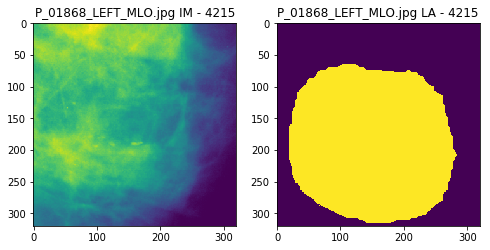

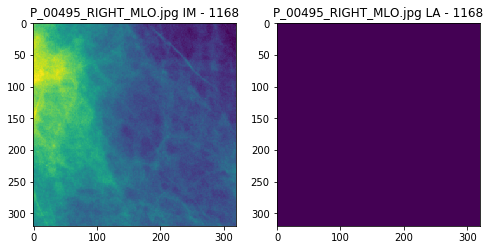

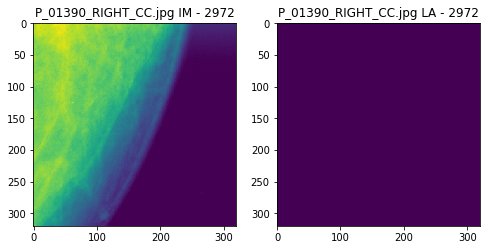

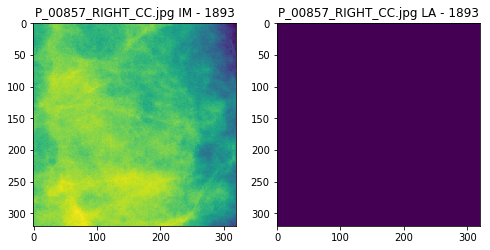

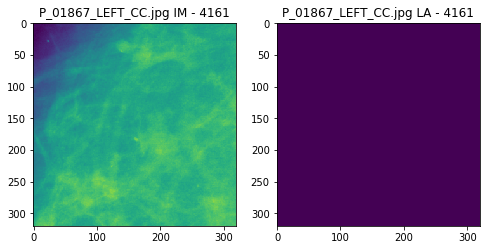

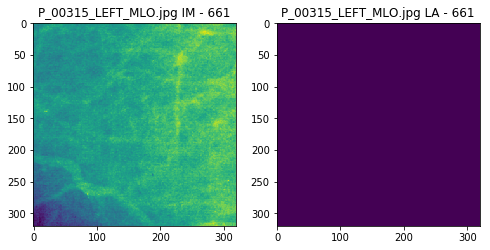

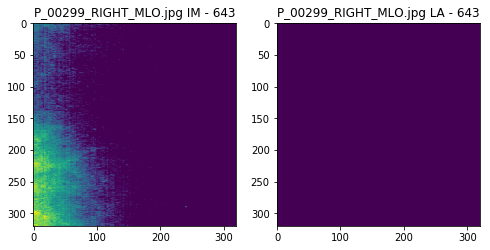

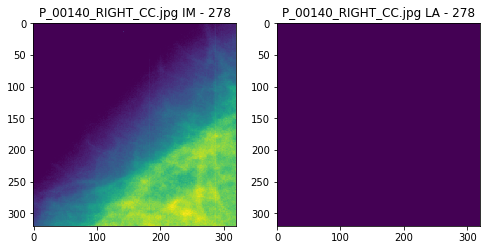

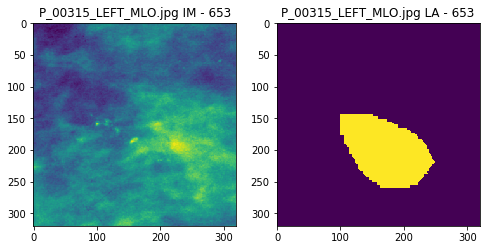

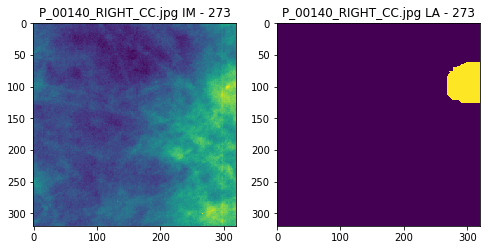

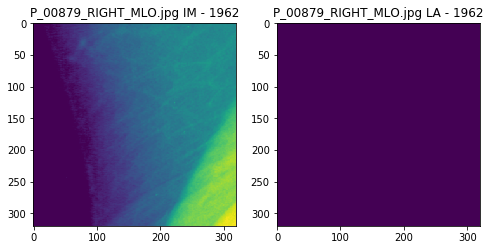

In [46]:
plot_random_samples(calc_test_slices, calc_test_labels, calc_testfilenames, N=20)

In [40]:
# scale the image data
# calc_test_slices = (calc_test_slices - 127.0) / 255.0
calc_test_slices = calc_test_slices.astype(np.uint8)

# relabel the labels
calc_test_labels[calc_test_labels > 0] = 1
calc_test_labels = calc_test_labels.astype(np.uint8)

In [47]:
np.save(os.path.join("data", "calc_test_slices12.npy"), calc_test_slices)
np.save(os.path.join("data", "calc_test_filenames12.npy"), calc_testfilenames)
np.save(os.path.join("data", "calc_test_labels12.npy"), np.array(calc_test_labels))

In [48]:
np.mean(calc_test_labels)

0.09501800375845487

In [49]:
del(calc_test_slices, calc_test_labels)

## Mass Test

In [50]:
# load the labels
test_labels = pd.read_pickle(os.path.join("data", "test_labels.pkl"))
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Mass Test All Mask JPEGs"
image_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Mass Test All Full JPEGs"

mass_test_slices, mass_test_labels, mass_testfilenames, mass_test_roi_sizes = create_cbis_slices(mask_dir, image_dir, labels=test_labels, debug=None)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:77: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Mass Test All Mask JPEGs/P_00145_LEFT_CC_MASK.jpg
Mask Size Error: 0 for P_00145_LEFT_CC_MASK.jpg
Error, skipping P_00145_LEFT_CC_MASK.jpg
Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Mass Test All Mask JPEGs/P_00145_LEFT_MLO_MASK.jpg
Mask Size Error: 0 for P_00145_LEFT_MLO_MASK.jpg
Error, skipping P_00145_LEFT_MLO_MASK.jpg
Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Mass Test All Mask JPEGs/P_00379_LEFT_MLO_MASK.jpg
Mask Size Error: 0 for P_00379_LEFT_MLO_MASK.jpg
Error, skipping P_00379_LEFT_MLO_MASK.jpg
Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Mass Test All Mask JPEGs/P_00381_LEFT_CC_MASK.jpg
Mask Size Error: 0 for P_00381_LEFT_CC_MASK.jpg
Error, skipping P_00381_LEFT_CC_MASK.jpg
Mask shape doesn't mat

In [51]:
print("Mass Test Slices shape:", mass_test_slices.shape)
print("Mass Test Labels:", len(mass_test_labels))
print("Mass Test File Name List:", len(mass_testfilenames))

Mass Test Slices shape: (5324, 320, 320, 1)
Mass Test Labels: 5324
Mass Test File Name List: 5324


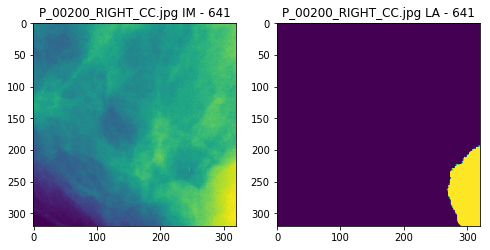

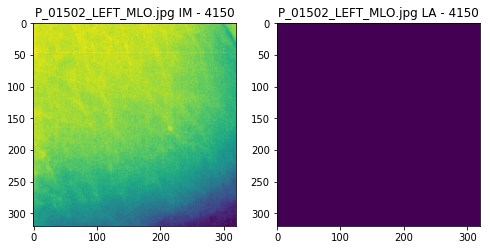

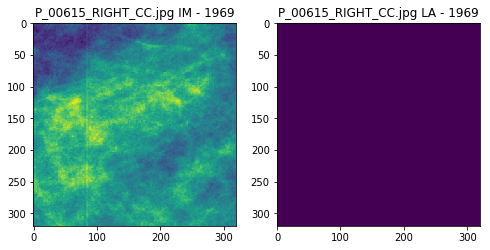

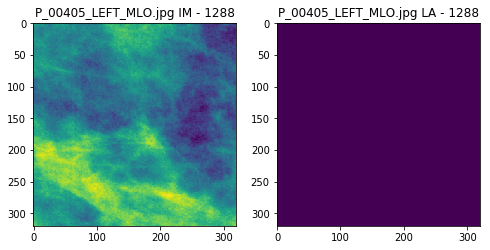

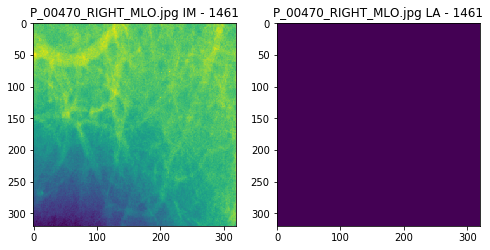

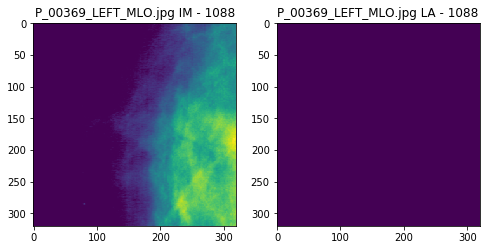

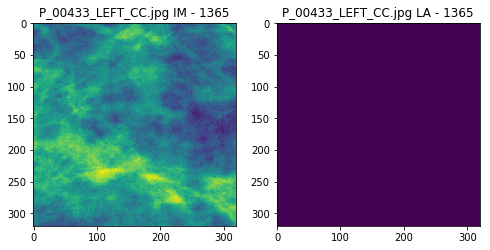

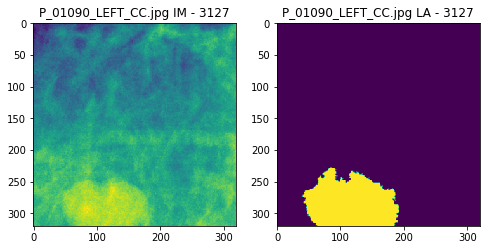

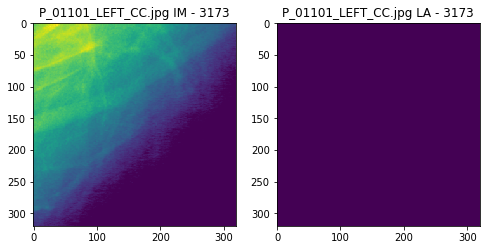

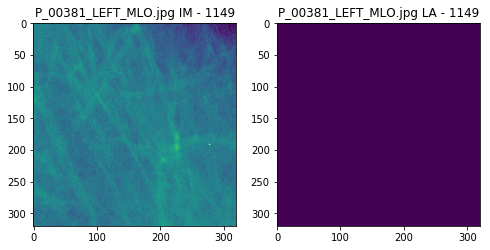

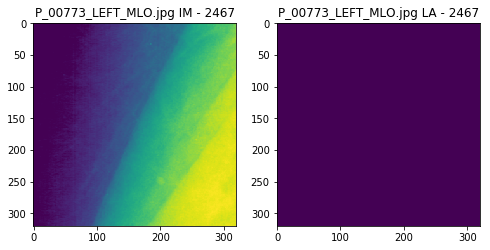

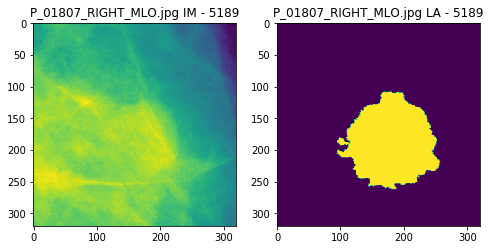

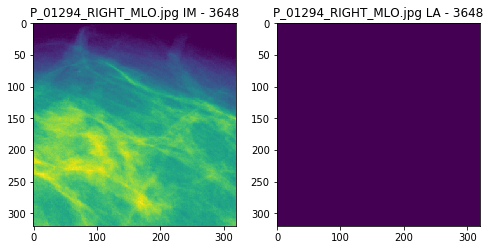

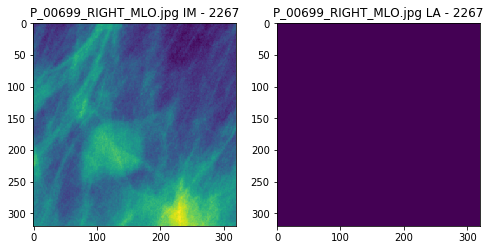

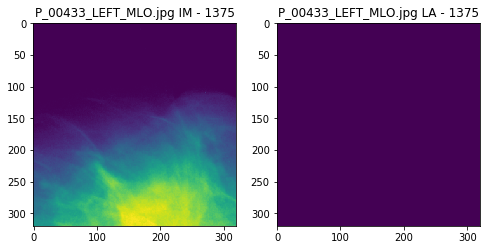

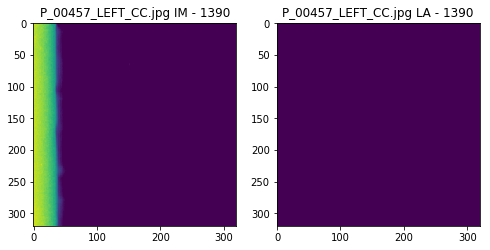

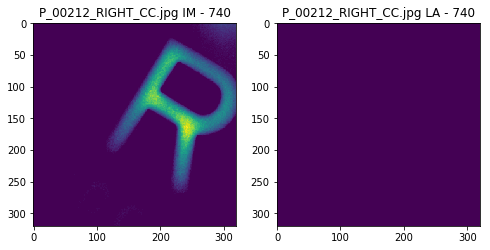

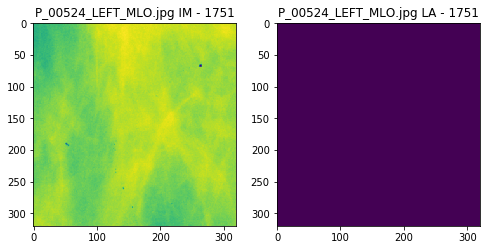

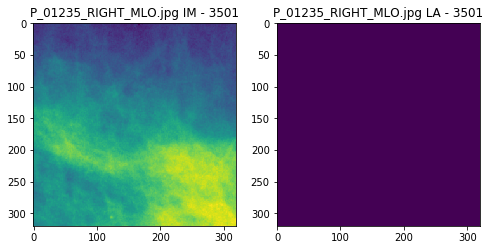

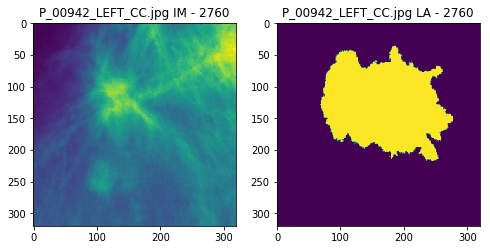

In [52]:
plot_random_samples(mass_test_slices, mass_test_labels, mass_testfilenames, N=20)

In [53]:
# scale the image data
# mass_test_slices = (mass_test_slices - 127.0) / 255.0
mass_test_slices = mass_test_slices.astype(np.uint8)

# relabel the labels
mass_test_labels[mass_test_labels > 0] = 1
mass_test_labels = mass_test_labels.astype(np.uint8)

In [54]:
np.mean(mass_test_labels)

0.054381298864810294

In [55]:
np.save(os.path.join("data", "mass_test_slices12.npy"), mass_test_slices)
np.save(os.path.join("data", "mass_test_filenames12.npy"), mass_testfilenames)
np.save(os.path.join("data", "mass_test_labels12.npy"), mass_test_labels)

In [57]:
del(mass_test_slices, mass_test_labels)

## Calc Train

In [58]:
train_labels = pd.read_pickle(os.path.join("data", "train_labels.pkl"))
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Calc Train All Mask JPEGs Full"
image_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Calc Train All Full JPEGs"

calc_train_slices, calc_train_labels, calc_trainfilenames, calc_train_roi_sizes = create_cbis_slices(mask_dir, image_dir, labels=train_labels, debug=None)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:77: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [59]:
print("Calc Train Slices shape:", calc_train_slices.shape)
print("Calc Train Labels:", len(calc_train_labels))
print("Calc Train File Name List:", len(calc_trainfilenames))

Calc Train Slices shape: (18726, 320, 320, 1)
Calc Train Labels: 18726
Calc Train File Name List: 18726


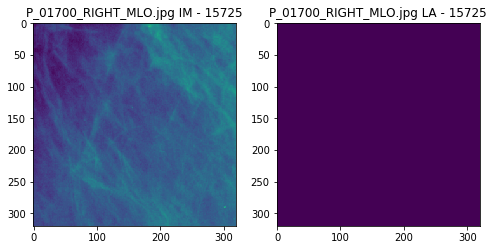

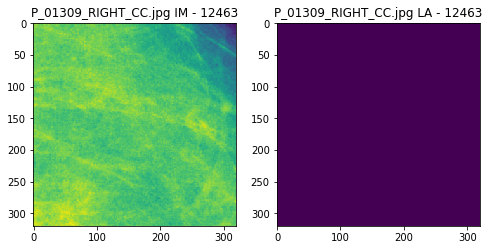

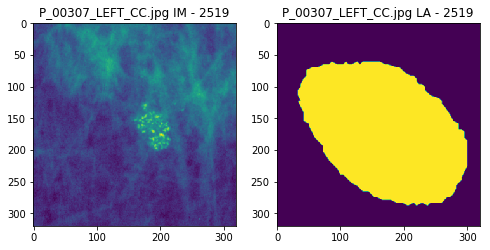

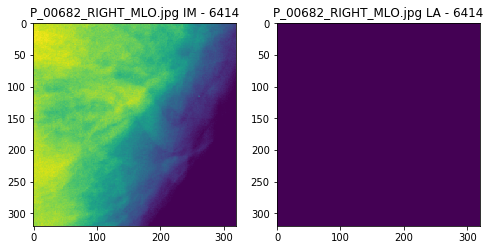

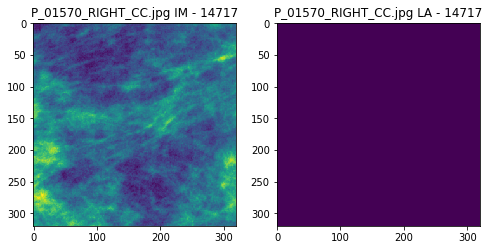

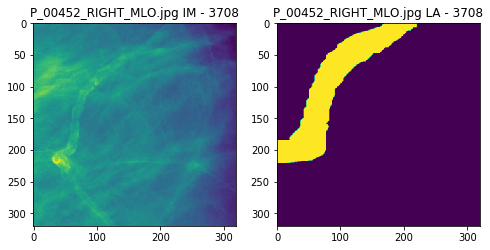

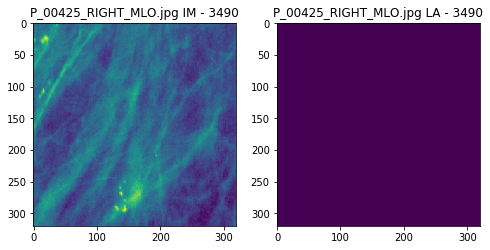

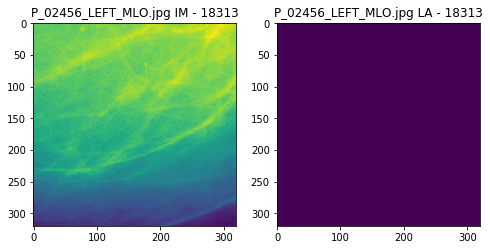

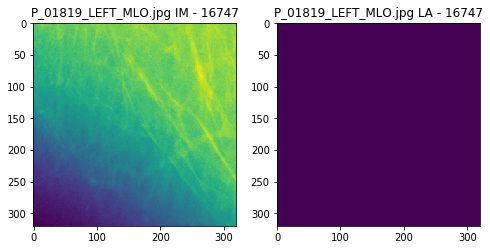

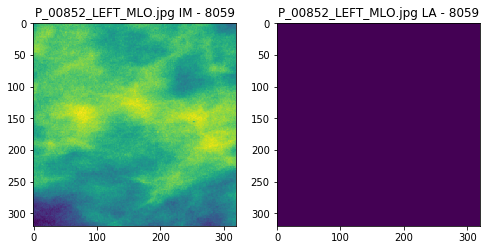

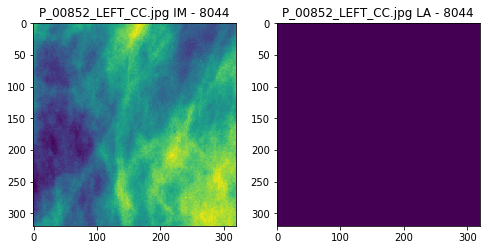

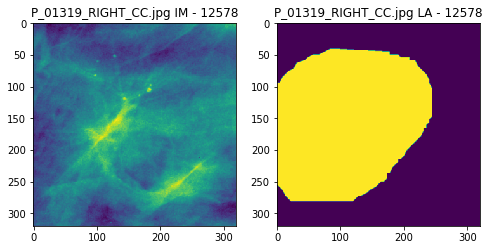

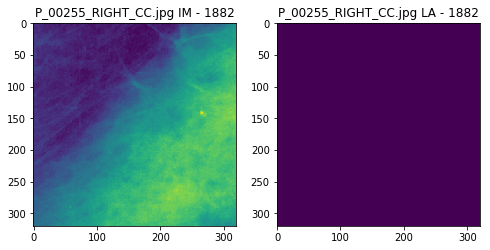

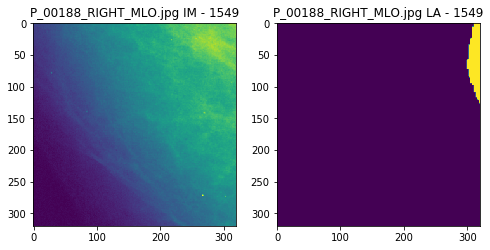

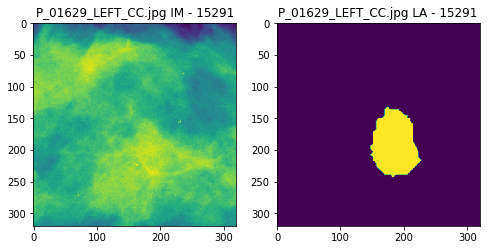

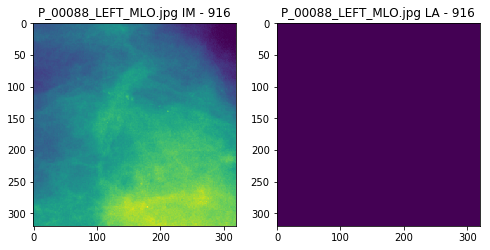

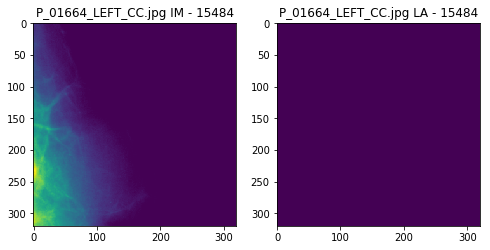

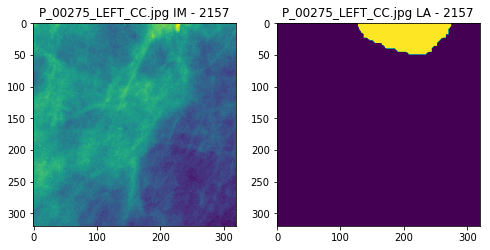

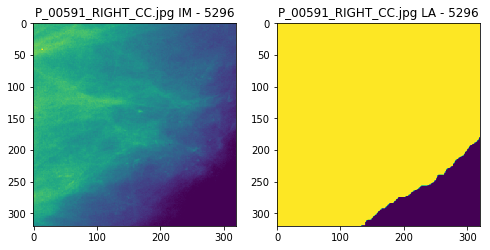

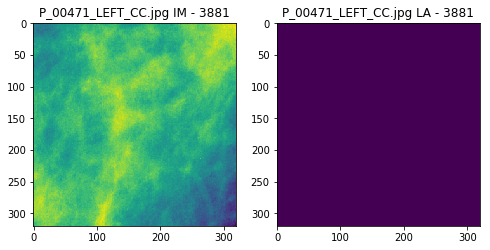

In [60]:
plot_random_samples(calc_train_slices, calc_train_labels, calc_trainfilenames, N=20)

In [61]:
# scale the image data
# mass_test_slices = (mass_test_slices - 127.0) / 255.0
calc_train_slices = calc_train_slices.astype(np.uint8)

# relabel the labels
calc_train_labels[calc_train_labels > 0] = 1
calc_train_labels = calc_train_labels.astype(np.uint8)

In [62]:
np.mean(calc_train_labels)

0.10946024244366122

In [63]:
np.save(os.path.join("data", "calc_train_slices12.npy"), calc_train_slices)
np.save(os.path.join("data", "calc_train_filenames12.npy"), calc_trainfilenames)
np.save(os.path.join("data", "calc_train_labels12.npy"), calc_train_labels)

In [64]:
del(calc_train_slices, calc_train_labels)

## Mass Train

In [67]:
train_labels = pd.read_pickle(os.path.join("data", "train_labels.pkl"))
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Mass Train All Mask JPEGs Full"
image_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Mass Train All JPEGs Full"

mass_train_slices, mass_train_labels, mass_trainfilenames, mass_train_roi_sizes = create_cbis_slices(mask_dir, image_dir, labels=train_labels, debug=None)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:77: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Error FileNotFound: P_00279_LEFT_MLO-------------------------] 13.8% ...P_00279_LEFT_MLO000000.jpg
Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Mass Train All Mask JPEGs Full/P_00423_RIGHT_CC_MASK.jpg
Mask Size Error: 0 for P_00423_RIGHT_CC_MASK.jpg
Error, skipping P_00423_RIGHT_CC_MASK.jpg
Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Mass Train All Mask JPEGs Full/P_00453_LEFT_CC_MASK.jpg
Mask Size Error: 0 for P_00453_LEFT_CC_MASK.jpg
Error, skipping P_00453_LEFT_CC_MASK.jpg
Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Mass Train All Mask JPEGs Full/P_00687_LEFT_CC_MASK.jpg
Mask Size Error: 0 for P_00687_LEFT_CC_MASK.jpg
Error, skipping P_00687_LEFT_CC_MASK.jpg
Mask shape doesn't match image! C:\Users\eric\Documents\Courses\Applied ML 2\mammography\data\cbis-ddsm\Mass Train All Mask JPEGs Full/P_00687_LEFT_MLO

In [68]:
print("Mass Train Slices shape:", mass_train_slices.shape)
print("Mass Train Labels:", mass_train_labels.shape)
print("Mass Train File Name List:", len(mass_trainfilenames))

Mass Train Slices shape: (18029, 320, 320, 1)
Mass Train Labels: (18029, 320, 320, 1)
Mass Train File Name List: 18029


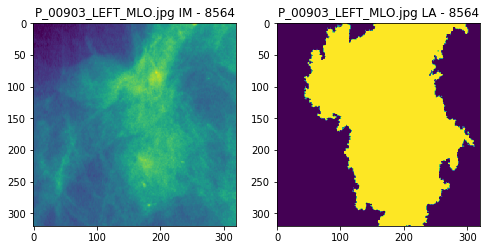

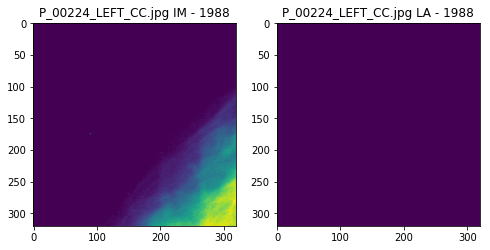

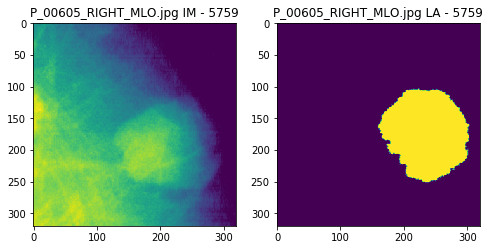

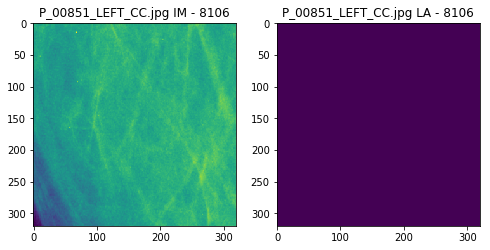

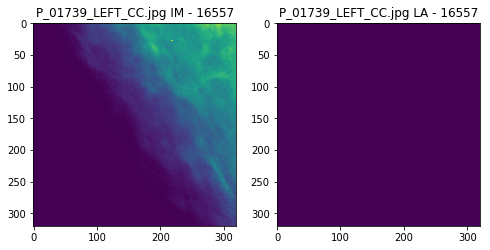

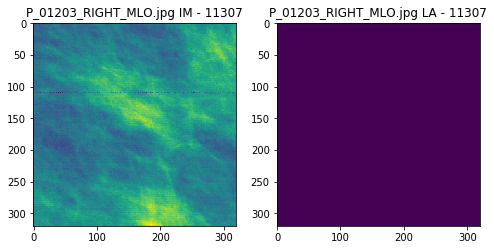

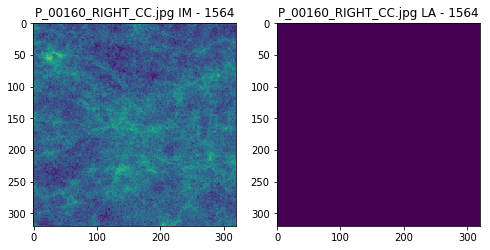

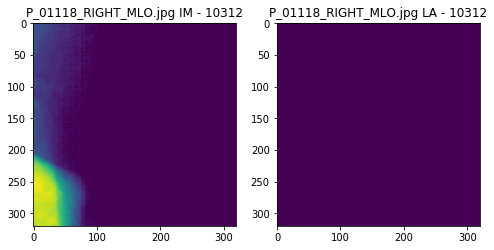

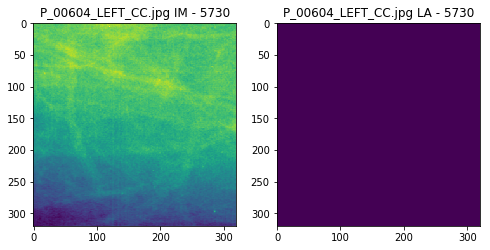

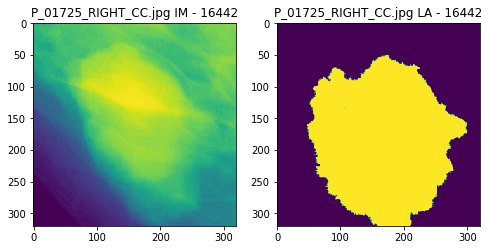

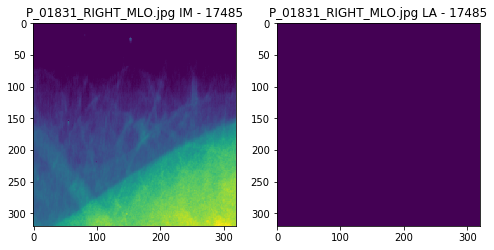

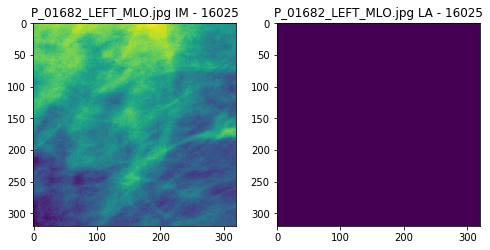

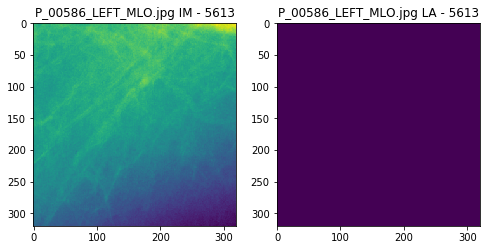

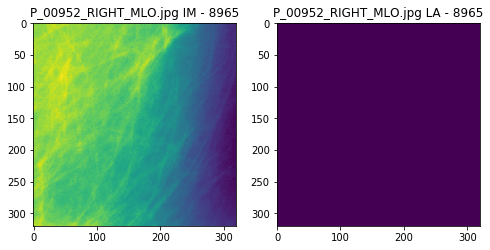

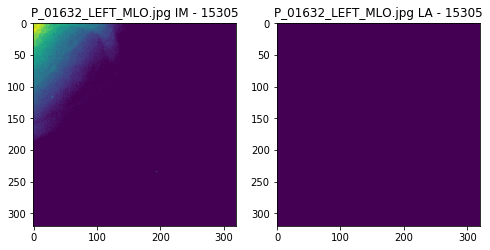

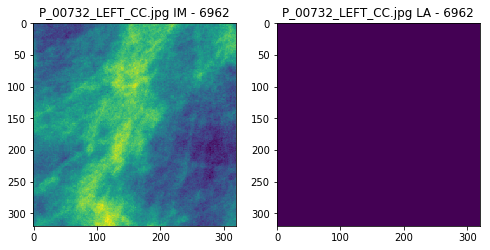

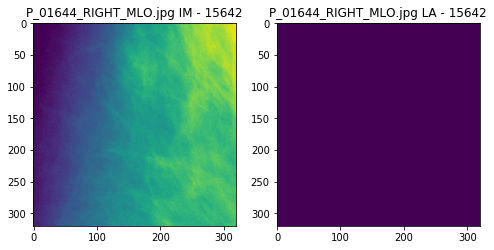

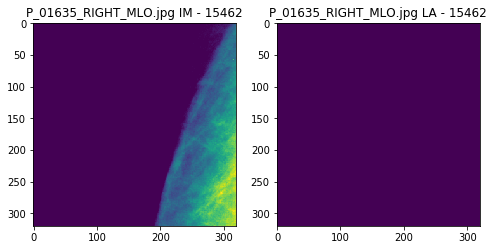

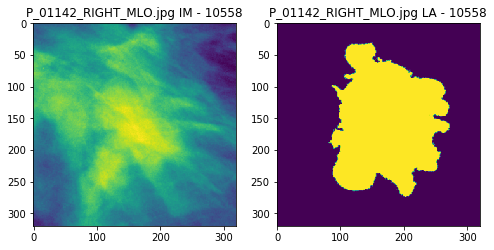

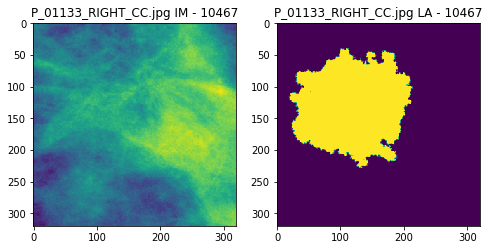

In [69]:
plot_random_samples(mass_train_slices, mass_train_labels, mass_trainfilenames, N=20)

In [70]:
# scale the image data
# mass_test_slices = (mass_test_slices - 127.0) / 255.0
mass_train_slices = mass_train_slices.astype(np.uint8)

# relabel the labels
mass_train_labels[mass_train_labels > 0] = 1
mass_train_slices = mass_train_slices.astype(np.uint8)

In [71]:
np.mean(mass_train_labels)

0.05662749402871762

In [72]:
np.save(os.path.join("data", "mass_train_slices12.npy"), mass_train_slices)
np.save(os.path.join("data", "mass_train_filenames12.npy"), mass_trainfilenames)
np.save(os.path.join("data", "mass_train_labels12.npy"), mass_train_labels)

## Combine Slices

In [ ]:
mass_train_labels = np.load(os.path.join("data", "mass_train_labels12.npy"))
calc_train_labels = np.load(os.path.join("data", "calc_train_labels12.npy"))

mass_train_slices = np.load(os.path.join("data", "mass_train_slices12.npy"))
calc_train_slices = np.load(os.path.join("data", "calc_train_slices12.npy"))

mass_train_names = np.load(os.path.join("data", "mass_train_filenames12.npy"))
calc_train_names = np.load(os.path.join("data", "calc_train_filenames12.npy"))

train_labels = np.concatenate([mass_train_labels, calc_train_labels], axis=0)
train_names = np.concatenate([mass_train_names, calc_train_names], axis=0)
train_slices = np.concatenate([mass_train_slices, calc_train_slices], axis=0)

print("Train labels:", train_labels.shape)
print("Train slices:", train_slices.shape)
print("Train filenames:", train_names.shape)

In [3]:
np.save(os.path.join("data", "cbis_train_slices12.npy"), train_slices)
np.save(os.path.join("data", "cbis_train_labels12.npy"), train_labels)
np.save(os.path.join("data", "cbis_train_names12.npy"), train_names)

In [4]:
del(train_labels, train_slices, mass_train_labels , mass_train_slices, calc_train_labels, calc_train_slices)

In [5]:
mass_test_labels = np.load(os.path.join("data", "mass_test_labels12.npy"))
calc_test_labels = np.load(os.path.join("data", "calc_test_labels12.npy"))

mass_test_slices = np.load(os.path.join("data", "mass_test_slices12.npy"))
calc_test_slices = np.load(os.path.join("data", "calc_test_slices12.npy"))

mass_test_names = np.load(os.path.join("data", "mass_test_filenames12.npy"))
calc_test_names = np.load(os.path.join("data", "calc_test_filenames12.npy"))

test_slices = np.concatenate([mass_test_slices, calc_test_slices], axis=0)
test_labels = np.concatenate([mass_test_labels, calc_test_labels], axis=0)
test_names = np.concatenate([mass_test_names, calc_test_names], axis=0)

print("Test labels:", test_labels.shape)
print("Test slices:", test_slices.shape)
print("Test filenames:", test_names.shape)

Test labels: (10055, 320, 320, 1)
Test slices: (10055, 320, 320, 1)
Test filenames: (10055,)


In [6]:
np.save(os.path.join("data", "cbis_test_slices12.npy"), test_slices)
np.save(os.path.join("data", "cbis_test_labels12.npy"), test_labels)
np.save(os.path.join("data", "cbis_test_names12.npy"), test_names)